# **Anime Recommendation System**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Dot, Dense, Embedding, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

## **Reading animelist.csv**

In [2]:
import os
INPUT_DIR = os.path.join("..", "artifacts", "raw")
rating_df = pd.read_csv(INPUT_DIR + "/animelist.csv", low_memory=True, usecols=['user_id', 'anime_id', 'rating'])

In [3]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [4]:
rating_df.shape

(5000000, 3)

### **Data Processing**

In [5]:
# Step 1: Compute rating counts per user and rename columns for clarity
counts = (rating_df["user_id"].value_counts().reset_index(name="n_ratings").rename(columns={"index": "user_id"}))

In [6]:
# Step 2: Identify users with at least 400 ratings
experienced_users = counts.loc[counts["n_ratings"] >= 400, "user_id"]

In [7]:
# Step 3: Filter the original DataFrame for those users
rating_df_filtered = rating_df[rating_df["user_id"].isin(experienced_users)].copy()

In [8]:
print(f"Total ratings after filtering: {len(rating_df_filtered)}")
print(rating_df_filtered["user_id"].value_counts().min(), "ratings (minimum per user in the filtered set)")

Total ratings after filtering: 3246641
400 ratings (minimum per user in the filtered set)


In [9]:
# Min and max rating
min_ratinggs = min(rating_df_filtered["rating"])
max_rating = max(rating_df_filtered["rating"])
avg_rating = np.mean(rating_df_filtered["rating"])

print(f"Min rating: {min_ratinggs}, Max rating: {max_rating}, Average rating: {avg_rating}")

Min rating: 0, Max rating: 10, Average rating: 4.122732695114736


In [10]:
# Checking for missing and duplicates values
print(rating_df_filtered.isna().sum())
print(rating_df_filtered.duplicated().sum())

user_id     0
anime_id    0
rating      0
dtype: int64
0


### **Scaling**

In [11]:
rating_df = rating_df_filtered.copy()

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the 'rating' column
rating_df['rating'] = scaler.fit_transform(rating_df[['rating']])


In [12]:
# Min and max rating
min_ratinggs = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])

print(f"Min rating: {min_ratinggs}, Max rating: {max_rating}, Average rating: {avg_rating}")

Min rating: 0.0, Max rating: 1.0, Average rating: 0.4122732695114729


### **Encoding**

In [13]:
# Storing all the unique user IDs in a list
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {user_id: i for i, user_id in enumerate(user_ids)}
user2user_decoded = {i: user_id for i, user_id in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [14]:
rating_df.head()         # Heere user_id is mapped in user column

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [15]:
# Total number of users in the filtered dataset
n_user = len(user2user_encoded)
n_user

4203

In [16]:
# Similar encoding for the Anime IDs
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {anime_id: i for i, anime_id in enumerate(anime_ids)}
anime2anime_decoded = {i: anime_id for i, anime_id in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [17]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [18]:
# Total number of anime series in the filtered dataset
n_anime = len(anime2anime_encoded)
n_anime

17149

### **Shuffling the data and splitting**

In [19]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"].values

In [20]:
# Splitting the data into train and tesrt sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# creating seperate list for each column inside a single array
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [22]:
X_train_array

[array([  27, 2173,  482, ..., 2881, 3569, 2870], shape=(2597312,)),
 array([2700, 2056,  197, ..., 5028,  175, 1895], shape=(2597312,))]

### **Model Architecture**

In [23]:
def RecommenderNet():
    # Each user and anime will be represented by a 128-dimensional vector
    embedding_size = 128
    
    # Maps each user to a 128-dimensional vector. 
    user = Input(name = "user", shape = [1])
    user_embedding = Embedding(name = "user_embedding", input_dim = n_user, output_dim = embedding_size)(user)
    
    # Maps each anime to a 128-dimensional vector.
    anime = Input(name = "anime", shape = [1])
    anime_embedding = Embedding(name = "anime_embedding", input_dim = n_anime, output_dim = embedding_size)(anime)
    
    # Gives cosine similarity between user and anime embeddings
    x = Dot(name = "dot_product", normalize = True, axes = 2)([user_embedding, anime_embedding])     
    
    # Converting multidimensional vector into single dimension vector || Flatten() then pass the prev x layer
    x = Flatten()(x)     
    
    # Adds a fully connected layer to learn a weighted sum of the similarity score, output is single value
    x = Dense(1, kernel_initializer = "he_normal")(x)
    x = BatchNormalization()(x)  # Normalizing the output
    x = Activation("sigmoid")(x)
    
    # Inputs: User and anime || Output: Probability that the user likes the anime
    model = Model(inputs = [user, anime], outputs = x)
    model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["mae", "mse"])
    return model
    

In [24]:
model = RecommenderNet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [25]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000
ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

# Help us find the best learning rate for our model -- from StackOverflow
def lrfn(epoch):    
    if epoch < ramup_epochs:
        lr = (max_lr - start_lr) / ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        lr = max_lr
    else:
        lr = (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr
    return lr

lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose = True)
checkpoint_filepath = './weights.weights.h5'
model_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1, mode='min')

my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [26]:
history = model.fit(x =X_train_array, 
                    y=y_train,
                    batch_size=batch_size, 
                    epochs=20, 
                    verbose = True,
                    validation_data=(X_test_array, y_test), 
                    callbacks=my_callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.8025 - mae: 0.3825 - mse: 0.1980
Epoch 1: val_loss improved from None to 0.72737, saving model to ./weights.weights.h5
260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - loss: 0.8025 - mae: 0.3825 - mse: 0.1979 - val_loss: 0.7274 - val_mae: 0.3682 - val_mse: 0.1711 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.7991 - mae: 0.3812 - mse: 0.1967
Epoch 2: val_loss did not improve from 0.72737
260/260 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.7992 - mae: 0.3812 - mse: 0.1966 - val_loss: 0.7855 - val_mae: 0.3794 - val_mse: 0.1924 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.7938 - mae: 0.3790 - mse: 0.1945
Epoch 3: val_l

In [27]:
def extract_weights(name, model):
    # Finds the embedding layer in the model by its name (e.g., "anime_embedding" or "user_embedding").
    weight_layer = model.get_layer(name)
    # Extracts the actual weights (embedding matrix) from the layer.
    weights = weight_layer.get_weights()[0]
    # normalizes each vector to have unit length, so each embedding vector points in the same dir but has a length of 1
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights 

anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)

## **Reading anime.csv**

In [28]:
df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [29]:
# Replacing Unknown values with np.nan
df = df.replace("Unknown", np.nan)

In [30]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name 

df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

In [31]:
df.sort_values(by = ["Score"], inplace = True, ascending = False, kind = "quicksort", na_position = "last")

In [32]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [33]:
# Filtering out unessary columns
df = df[["anime_id", "eng_version", "Score", "Genres", "Type", "Episodes", "Premiered", "Members"]]

In [34]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    elif isinstance(anime, str):
        return df[df.eng_version == anime]
    else:
        print("Incorrect name or id emtered")

## **Reading anime_with_synopsis.csv**

In [35]:
# Filtering out unessary columns
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
synopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', usecols=cols)

In [36]:
def getSynopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    elif isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    else:
        print("Incorrect name or id emtered")

In [37]:
getSynopsis(40028, synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

# **Content based Recommendation System**

In [38]:
# in order to view hte entire data of synopsis column
pd.set_option("max_colwidth", None)

In [39]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, 
                        df, synopsis_df, n=10, return_dist=False, neg=False):
    try:
        # Fetching the original index from df
        index = getAnimeFrame(name, df).anime_id.values[0]
        
        # Fetching the encoded index from the trained model df
        encoded_index = anime2anime_encoded.get(index) 
        
        # Calculation of the weight of all the anime w.r.t the particular anime and sort from least similar to most similar
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index]) 
        sorted_dists = np.argsort(dists)
        
        # Want the target anime to be included in the list
        n = n+1 
        
        # If neg=True will get least similar anime || neg=False most similar anime
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        
        # If user sets return_dist=true it will return, but here it is false   
        if return_dist:
            return dists, closest
        
        # Sreating an emmpty list then append the similar ones in it
        SimilarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            anime_frame = getAnimeFrame(decoded_id, df)
            anime_name = anime_frame.eng_version.values[0]
            genres = anime_frame.Genres.values[0]
            similarity = dists[close]
            
            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genres
            })
        
        # Converting the nested list dict to pandas df and sorting them in descending order
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        
        # Dropping the target anime name because it is of no use
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis = 1)    
    
    except Exception as e:
        print("Error Occure...", e)

In [40]:
find_similar_animes("Dragon Ball", anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=2)

,name,similarity,genre
1,R.O.D -The TV-,0.325088,"Action, Sci-Fi, Adventure, Comedy, Super Power, Drama"
0,Bokunchi no Chabo,0.301682,"Music, Kids"


# **Collaborative based Recommendation System**

In [41]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        index=item_input
        encoded_index=user2user_encoded.get(index)
        weights = user_weights
        
        # Compute cosine-style similarities (dot products)
        dists = np.dot(weights, weights[encoded_index]) 
        sorted_dists = np.argsort(dists)
        
        # Want the target anime to be included in the list
        n=n+1 
        
        # If neg=True will get least similar anime || neg=False most similar anime
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        
        # If user sets return_dist=true it will return, but here it is false   
        if return_dist:
            return dists, closest
        
        # Sreating an emmpty list then append the similar ones in it
        rows = []
        for close in closest:
            sim = dists[close]
            decoded_id = user2user_decoded.get(close)
            rows.append({
                "similar_user": decoded_id,
                "similarity": sim,
            })

        df = pd.DataFrame(rows)
        # Exclude the target user by filtering on the correct column name
        df = df[df.similar_user != item_input]
        # Sort descending by similarity
        df = df.sort_values("similarity", ascending=False).reset_index(drop=True)

        return df   
    
    except Exception as e:
        print("Error Occure...", e)
        

In [42]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

,similar_user,similarity
0,4166,0.291663
1,16062,0.287284
2,14638,0.285680
3,13744,0.261889
4,5349,0.261596
5,10025,0.260209
6,613,0.258225
7,5813,0.252783
8,927,0.249182
9,13004,0.244815


### **VISUALIZATION**

In [43]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

from collections import defaultdict    
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres=defaultdict(int) 
    
    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    
    if plot:
        showWordCloud(all_genres)
        
    return genres_list

In [44]:
x = getAnimeFrame(1, df)
x

,anime_id,eng_version,Score,Genres,Type,Episodes,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,Spring 1998,1251960


In [45]:
getFavGenre(x)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

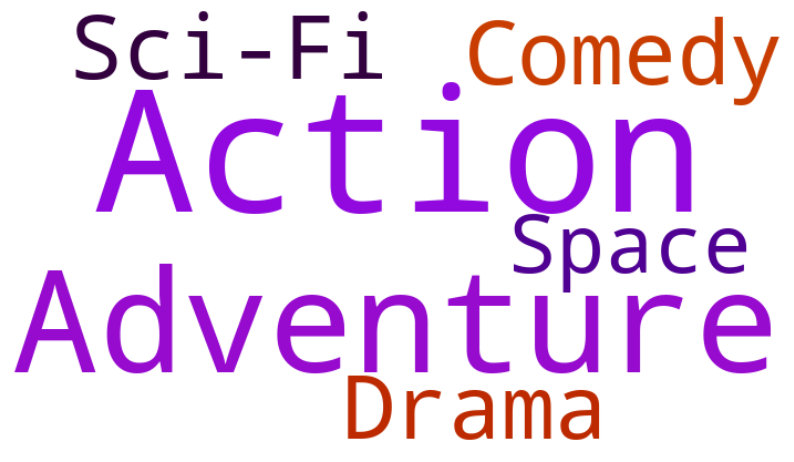

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [46]:
getFavGenre(x, plot=True)

### **Extract user preferences**

In [ ]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (animes_watched_by_user.sort_values(by='rating', ascending=False).anime_id.values)
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]
    
    if plot==True:
        getFavGenre(anime_df_rows, plot)
    else:
        return anime_df_rows

In [48]:
get_user_preferences(11880, rating_df, df, plot=False)

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


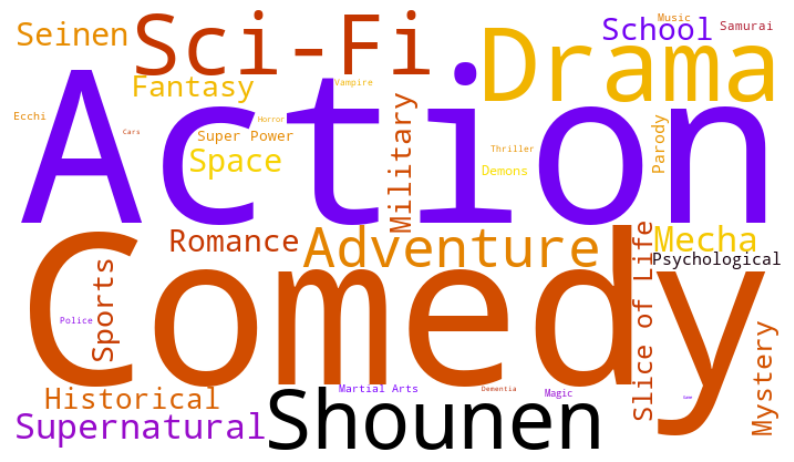

In [49]:
get_user_preferences(11880, rating_df, df, plot=True)

### **USER BASED RECOMMENDATION**

In [50]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded).head(3)

,similar_user,similarity
0,4166,0.291663
1,16062,0.287284
2,14638,0.285680


In [51]:
def get_user_recommendations(similar_user, user_pref, df, synopsis_df, rating_df, n=10):
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_user.similar_user.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)
        
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]
        
        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
            
    if anime_list:
        anime_list = pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts().head(n))
                
        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
                    
            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id), synopsis_df)
                        
                recommended_animes.append({
                    "n" : n_user_pref,
                    "anime_name" : anime_name,
                    "genre" : genre,
                    "synopsis" : synopsis
                })
                        
    return pd.DataFrame(recommended_animes).head(n)

In [52]:
similar_user = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)
user_pref = get_user_preferences(11880, rating_df, df)
get_user_recommendations(similar_user, user_pref, df, synopsis_df, rating_df, n=1)

,n,anime_name,genre,synopsis
0,10,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen","aku Ichijou, a first-year student at Bonyari High School, is the sole heir to an intimidating yakuza family. Ten years ago, Raku made a promise to his childhood friend. Now, all he has to go on is a pendant with a lock, which can only be unlocked with the key which the girl took with her when they parted. Now, years later, Raku has grown into a typical teenager, and all he wants is to remain as uninvolved in his yakuza background as possible while spending his school days alongside his middle school crush Kosaki Onodera. However, when the American Bee Hive Gang invades his family's turf, Raku's idyllic romantic dreams are sent for a toss as he is dragged into a frustrating conflict: Raku is to pretend that he is in a romantic relationship with Chitoge Kirisaki, the beautiful daughter of the Bee Hive's chief, so as to reduce the friction between the two groups. Unfortunately, reality could not be farther from this whopping lie—Raku and Chitoge fall in hate at first sight, as the girl is convinced he is a pathetic pushover, and in Raku's eyes, Chitoge is about as attractive as a savage gorilla. Nisekoi follows the daily antics of this mismatched couple who have been forced to get along for the sake of maintaining the city's peace. With many more girls popping up his life, all involved with Raku's past somehow, his search for the girl who holds his heart and his promise leads him in more unexpected directions than he expects."


# **Hybrid Recommendation System**

In [53]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):
    # User Recommendation
    similar_user = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommended_animes = get_user_recommendations(similar_user, user_pref, df, synopsis_df, rating_df)
    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    
    # Content Recommendation
    content_recommended_animes = []  
    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)
        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print("No Similar Anime found wrt, ", anime)
    
    combines_score = {}
    for anime in  user_recommended_anime_list:
        combines_score[anime] = combines_score.get(anime, 0) + user_weight
    for anime in content_recommended_animes:
        combines_score[anime] = combines_score.get(anime, 0) + content_weight
        
    sorted_animes = sorted(combines_score.items(), key = lambda x:x[1], reverse=True)
    return [anime for anime, score in sorted_animes[:10]]
             

In [54]:
hybrid_recommendation(11880)

['Nisekoi:False Love',
 'No Game, No Life',
 'Aldnoah.Zero',
 'Steins;Gate',
 'Fate/stay night [Unlimited Blade Works]',
 'Your Lie in April',
 'Toradora!',
 'Fate/Zero',
 'anohana:The Flower We Saw That Day',
 'Re:ZERO -Starting Life in Another World-']